# Flow Over Cylinder: SHRED reconstruction and prediction
The SHRED architecture is tested on the turbulent flow over cylinder for Re = 600, solved with dolfinx.

This notebook can run SHRED in two modes: reconstruction and prediction. In the former, the whole time interval of time is used to train the model and the test data are sampled within the same time interval. In the latter, the model is trained up to a certain time and tested beyond this, the measurements are supposed to be known for the whole interval.

Let us load the data

In [1]:
import numpy as np
import pickle
import gzip

path_snaps = '../../../Data/'

with gzip.open(path_snaps+'FlowOverCyl_snaps.pkl.gz', 'rb') as f:
    snaps, times, folder_list, domain = pickle.load(f)

times = np.array(times)
params = [float(folder.split('_')[1][:-1]) for folder in folder_list]
var_names = list(snaps.keys())
print('Loaded snapshots:', var_names)

tex_var_names = ['p', r'\mathbf{u}']

Nt = len(times)
Nh = len(domain)

Loaded snapshots: ['p', 'u']


In this notebook, a single transient is studied, choosing a single Reynolds number.

In [2]:
mu_i_selected = len(params) - 1
print('Selected Reynolds number:', params[mu_i_selected])
Ns = 1

snapshots = {
    field: snaps[field][mu_i_selected].reshape(1, snaps[field].shape[1], snaps[field].shape[2]) for field in var_names
}

Selected Reynolds number: 600.0


Let us perform the SVD

In [3]:
from sklearn.utils.extmath import randomized_svd

modes = dict()
sing_vals = dict()

rank = 50

for field in var_names:
    print('Computing SVD for field:', field)
    X = snapshots[field].reshape(-1, snapshots[field].shape[-1]).T
    U, S, _ = randomized_svd(X, n_components=rank, n_iter='auto')
    modes[field] = U
    sing_vals[field] = S

Computing SVD for field: p
Computing SVD for field: u


Let us plot the singular values

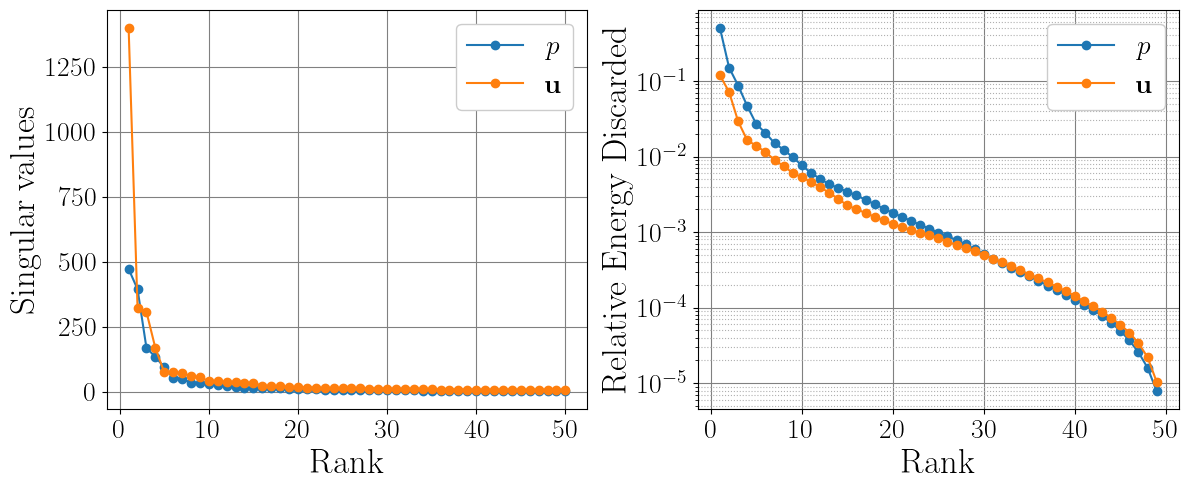

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

rank_plot = np.arange(1, rank+1)

for field_i, field in enumerate(var_names):
    axs[0].plot(rank_plot, sing_vals[field], 'o-', label=r'$'+tex_var_names[field_i]+'$')
    axs[1].semilogy(rank_plot[:-1], 1-np.cumsum(sing_vals[field][:-1] ** 2) / np.sum(sing_vals[field] ** 2), 'o-', label=r'$'+tex_var_names[field_i]+'$')

for ax in axs:
    ax.set_xlabel('Rank', fontsize=25)
    ax.legend(framealpha=1, loc='upper right', fontsize=20)
    ax.grid(which='major', linestyle='-', color='gray')
    ax.grid(which='minor', linestyle=':')
    ax.set_xticks(np.arange(0, rank+1, 10))
    ax.tick_params(axis='both', which='major', labelsize=20)

axs[0].set_ylabel('Singular values', fontsize=25)
axs[1].set_ylabel('Relative Energy Discarded', fontsize=25)

plt.tight_layout()

Let us define a plot function and plot the modes

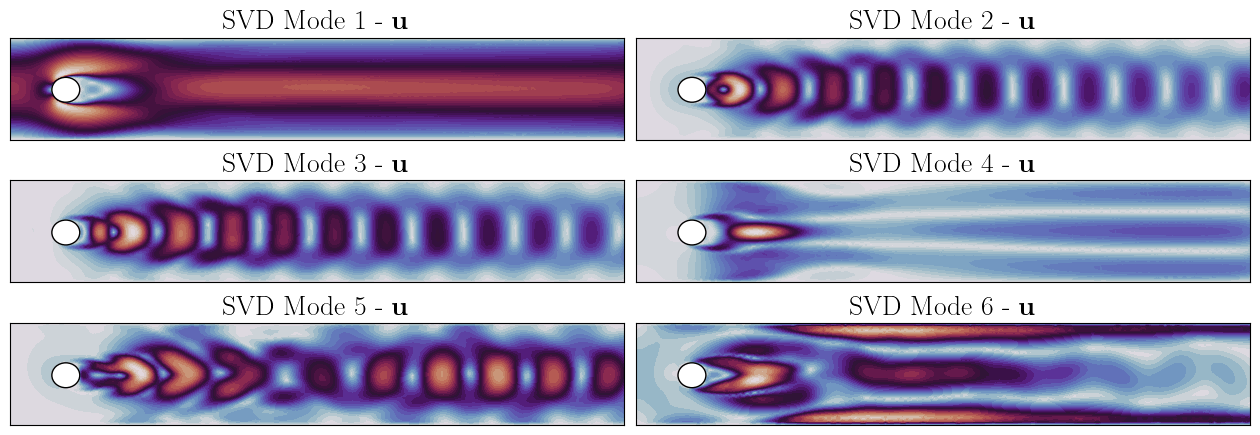

In [7]:
from utils import PlotFlowCyl
from matplotlib import cm

plotter = PlotFlowCyl(domain)

field_to_plot = 1
cmaps = [cm.brg, cm.twilight]

nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8 * ncols, (8+1) * nrows * plotter.aspect))
axs = axs.flatten()

for ii in range(nrows*ncols):
    plotter.plot_contour(axs[ii], modes[var_names[field_to_plot]][:, ii], cmap=cmaps[field_to_plot])
    axs[ii].set_title(r'SVD Mode %d - $%s$' % (ii+1, tex_var_names[field_to_plot]), fontsize=20)

fig.subplots_adjust(wspace=0.02, hspace=0.4)


Let us compute the POD coefficients

In [8]:
pod_coeff = dict()

for field in var_names:
    pod_coeff[field] = np.zeros((Ns, Nt, rank))
    for mu_i in range(snapshots[field].shape[0]):
        pod_coeff[field][mu_i] = np.dot(modes[field].T, snapshots[field][mu_i].reshape(-1, snapshots[field].shape[-1]).T).T

Let us plot the geometry

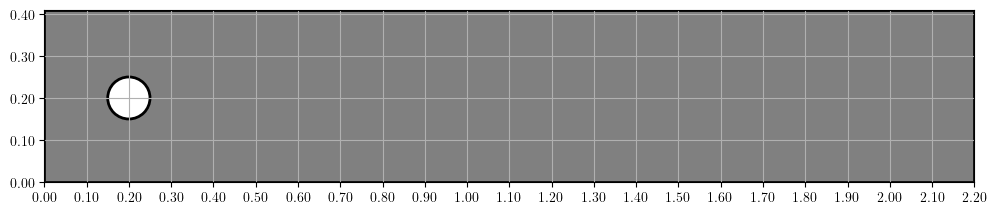

In [9]:
from matplotlib import patches

fig, axs = plt.subplots(1,1,figsize=(12, 12*plotter.aspect))

circ = plotter.create_circle(2)
rec = patches.Rectangle((domain[:,0].min(), domain[:,1].min()), domain[:,0].max()-domain[:,0].min(), domain[:,1].max()-domain[:,1].min(), edgecolor='black', facecolor='gray', linewidth=2)
axs.add_patch(rec)
axs.grid()
axs.add_patch(circ)

axs.set_xlim(domain[:,0].min(), domain[:,0].max())
axs.set_ylim(domain[:,1].min(), domain[:,1].max())

axs.set_xticks(np.arange(domain[:,0].min(), domain[:,0].max()+0.1, 0.1), [f"{x:.2f}" for x in np.arange(domain[:,0].min(), domain[:,0].max()+0.1, 0.1)])
axs.set_yticks(np.arange(domain[:,1].min(), domain[:,1].max(), 0.1), [f"{y:.2f}" for y in np.arange(domain[:,1].min(), domain[:,1].max(), 0.1)])

## SHRED

### Compute Measures
The SHRED architecture takes as input M sensor measures and maps them to the reduced space characterizing the transient scenario. The sensor are placed randomly in the domain and measure the $x$-component of the velocity $u_x$
\begin{equation*}
y^{u_x}_m = v_m (u_x)\cdot(1+ \epsilon_m)
\end{equation*}
where $v_m$ is a functional describing the sensor procedure (either point-wise or Gaussian averaged) and $\epsilon_m$ is a Gaussian noise with standard deviation $\sigma$.

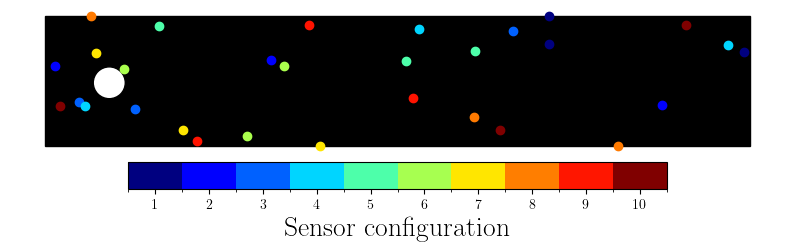

In [10]:
measured_field = 0

# Sampling the sensors locations
num_sensors = 3

n_configurations = 10
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)

np.random.seed(10) # For reproducibility
for kk in range(n_configurations):
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(Nh, size=num_sensors, replace=False), dtype=int)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(10, (10+2.5) * plotter.aspect))
ax = fig.add_subplot()

rec = Rectangle((domain[:,0].min(), domain[:,1].min()), domain[:,0].max()-domain[:,0].min(), domain[:,1].max()-domain[:,1].min(), edgecolor='black', facecolor='black')
ax.add_patch(rec)

circ = plotter.create_circle()
ax.add_patch(circ)

sens_c = cm.jet(np.linspace(0, 1, n_configurations))
for kk in range(n_configurations):
    ax.scatter(domain[idx_sensor_locations[:, kk], 0], domain[idx_sensor_locations[:, kk], 1], color=sens_c[kk], label='Sensor %d' % (kk+1))

ax.axis('off')

# Create a discrete colormap and normalization

import matplotlib.colors as mcolors
bounds = np.linspace(1, n_configurations+1, n_configurations+1)
norm = mcolors.BoundaryNorm(bounds, cm.jet.N)
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=norm)
sm.set_array([])

# Add the discrete colorbar to the plot
midpoints = (bounds[:-1] + bounds[1:]) / 2
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', ticks=np.arange(n_configurations + 1), pad=0.05, shrink=0.9)
cbar.ax.set_xticks(midpoints)
cbar.ax.set_xticklabels([f'{i}' for i in np.hstack([np.array([1]), np.arange(2, n_configurations + 1, 1, dtype=int)])])
cbar.set_label('Sensor configuration', fontsize=20)


Let us extract the measures

In [11]:
measurements = list()

for kk in range(n_configurations):

    measurements.append(np.zeros((1, len(times), num_sensors)))
    measurements[kk][0, :, :] = snapshots[var_names[measured_field]][0, :, idx_sensor_locations[:, kk]].T

print('Sensors Shape')
print(measurements[0].shape)

Sensors Shape
(1, 400, 3)


Let us add uncorrelated Gaussian noise to the measures

In [12]:
noise_value = 5e-2
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append(measurements[kk] * (1+np.random.normal(scale=noise_value, size=measurements[kk].shape)))

print('Sensors Shape')
print(Xsensor[0].shape)

Sensors Shape
(1, 400, 3)


Let us scale them to be in the range $[0, 1]$

In [13]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler      = list()

for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk].reshape(-1, num_sensors))
    rescaled_Xsensor.append(sens_scaler[kk].transform(Xsensor[kk].reshape(-1, num_sensors)).reshape(Xsensor[kk].shape))

Plotting some measures for a trajectory of the training set

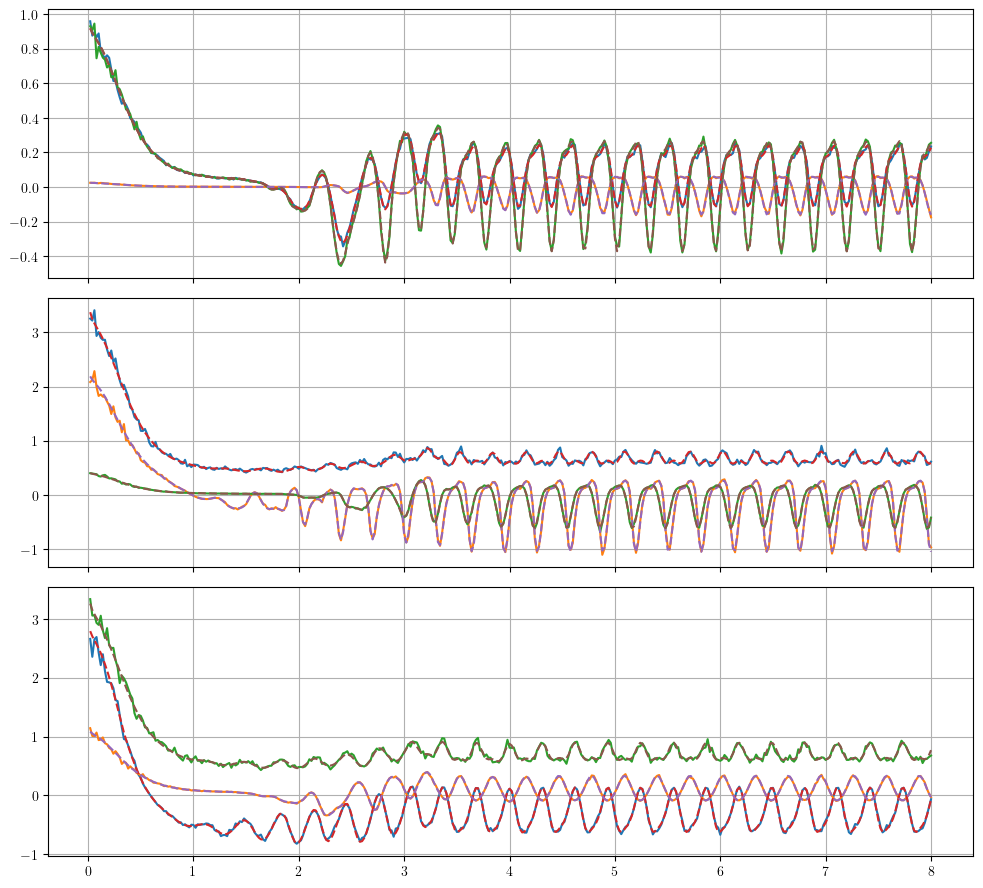

In [14]:
import matplotlib.pyplot as plt

ncols = 1
nrows = 3
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (10 * ncols, 3 * nrows))

if nrows == 1 and ncols == 1:
    axs = np.array([axs])

axs = axs.flatten()

param_to_plot = 0

for kk in range(nrows * ncols):
    axs[kk].plot(times, Xsensor[kk][param_to_plot])
    axs[kk].plot(times, measurements[kk][param_to_plot], '--')
    axs[kk].grid()
    
plt.tight_layout()

### Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [15]:
Nmodes = [20]*len(var_names)

_stacked_POD_coeff = np.concatenate([pod_coeff[var_names[field_i]][:, :, :Nmodes[field_i]] for field_i in range(len(var_names))], axis=-1)

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(_stacked_POD_coeff.reshape(-1, sum(Nmodes)))

rescaled_v_POD = vpod_scaler.transform(_stacked_POD_coeff.reshape(-1, sum(Nmodes))).reshape(_stacked_POD_coeff.shape)
print(rescaled_v_POD.shape)

(1, 400, 40)


### SHRED Training
Now, that we can all the ingredients to prepare the data for a SHRED approach: *SHRED is trained to predict the POD coefficients given 3 random measures*.

In [16]:
import sys
sys.path.append('/Users/sriva/Github/PublicRepo/NuSHRED') # Adjust this path as necessary

from shred.processdata import Padding, TimeSeriesDataset, num2p, mre
import torch
from shred.models import SHRED, fit
import os

# GPU
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

Let us prepare them for the SHRED architecture.

In [17]:
lags = 30

data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]), 
                    lags).to(device) for kk in range(n_configurations)]
data_out = Padding(torch.from_numpy(rescaled_v_POD), 1).squeeze(1).to(device)

output_size = data_out.shape[-1]

mode = 'reconstruction'  # 'reconstruction' or 'prediction'

if mode == 'reconstruction':
    # Reconstruction - splitting into train, test and validation
    np.random.seed(0)
    train_indices = np.sort(np.random.choice(Nt, size=250, replace=False))
    mask = np.ones(Nt)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, Nt)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]
elif mode == 'prediction':
    # # Prediction - splitting into train, test and validation
    # cut_train = 0.5
    # cut_valid = 0.75
    # train_indices = np.arange(0, int(cut_train * Nt))
    # valid_indices = np.arange(int(cut_train * Nt), int(cut_valid * Nt))
    # test_indices = np.arange(int(cut_valid * Nt), Nt)
    cut_train = 0.8
    cut_valid = 0.85
    train_indices = np.arange(0, int(cut_train * Nt), 2)
    valid_indices = np.arange(1, int(cut_valid * Nt), 2)
    test_indices = np.arange(int(cut_valid * Nt), Nt)
else:
    raise ValueError('Mode not recognized')

### Generate training validation and test datasets both for reconstruction of states
train_dataset = [TimeSeriesDataset(data_in[kk][train_indices], data_out[train_indices]) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(data_in[kk][valid_indices], data_out[valid_indices]) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(data_in[kk][test_indices],  data_out[test_indices])  for kk in range(n_configurations)]

Let us train the SHRED models for each configuration

In [18]:
import time
import pickle

path_shred = f'./Results/SHRED{mode}_rank{sum(Nmodes)}/'
os.makedirs(path_shred, exist_ok=True)

train_net = True

shred = list()

if train_net:
    comp_times = list() 
else:
    comp_times = pickle.load(open(path_shred+'comp_times.pkl', 'rb'))
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))
    
    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))
    
    if train_net:
        start = time.time()

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 3000, lr = 1e-3, verbose = True, patience = 75)

        shred[kk].freeze()
        torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'.shred')
        
        comp_times.append(time.time()-start)

        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'.shred',
                                             map_location=device))
        shred[kk].freeze()

if train_net:
    pickle.dump(comp_times, open(path_shred+'comp_times.pkl', 'wb'))
    

Training SHRED - configuration 1/10
Training done: Training loss = 2.21% 	 Validation loss = 3.42%        
 
Training SHRED - configuration 2/10
Training done: Training loss = 2.48% 	 Validation loss = 3.66%        
 
Training SHRED - configuration 3/10
Training done: Training loss = 2.41% 	 Validation loss = 4.67%        
 
Training SHRED - configuration 4/10
Training done: Training loss = 2.51% 	 Validation loss = 3.61%        
 
Training SHRED - configuration 5/10
Training done: Training loss = 2.76% 	 Validation loss = 3.73%        
 
Training SHRED - configuration 6/10
Training done: Training loss = 2.40% 	 Validation loss = 3.73%        
 
Training SHRED - configuration 7/10
Training done: Training loss = 2.59% 	 Validation loss = 3.92%        
 
Training SHRED - configuration 8/10
Training done: Training loss = 2.53% 	 Validation loss = 4.12%        
 
Training SHRED - configuration 9/10
Training done: Training loss = 2.54% 	 Validation loss = 3.71%        
 
Training SHRED - co

Checking the test errors on the POD coefficients

In [29]:
Ytest_POD_hat = torch.stack([shred[kk](test_dataset[kk].X) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0)[:, :sum(Nmodes)],
    'std':  Ytest_POD_hat.std(axis=0)[:,  :sum(Nmodes)] / np.sqrt(n_configurations)
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_dataset[0].Y[:, :sum(Nmodes)],
                                                                            Ytest_POD_pred['mean'])))
print("Std  relative SHRED prediction error on POD coeffs: %s." % num2p((Ytest_POD_pred['std'].pow(2).sum(axis = -1).sqrt() / (test_dataset[0].Y[:, :sum(Nmodes)]).pow(2).sum(axis = -1).sqrt()).mean()))

Mean relative SHRED prediction error on POD coeffs: 2.48%.
Std  relative SHRED prediction error on POD coeffs: 0.89%.


Let us compute the errors for each configuration

In [30]:
errors = {
    'mean': np.array([mre(test_dataset[0].Y[:, :sum(Nmodes)], Ytest_POD_hat[kk]).cpu().detach().numpy() for kk in range(n_configurations)])
}
errors['std'] = np.std(errors['mean'], axis=0)
errors

{'mean': array([0.03451814, 0.0333749 , 0.03504863, 0.03620943, 0.03481133,
        0.03316921, 0.0349918 , 0.03844186, 0.03638719, 0.04185272],
       dtype=float32),
 'std': 0.0024637978}

Let us plot the errors on each POD coefficient

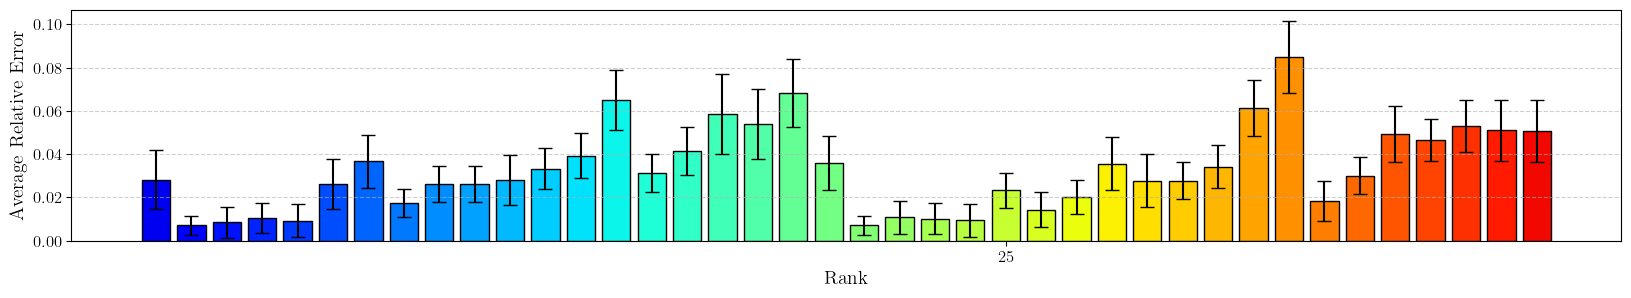

In [31]:
errors_per_coeff = {
    'mean': [(mre(Ytest_POD_pred['mean'][:, rr], test_dataset[0].Y[:, rr])).item() for rr in range(sum(Nmodes))],
    'std':  [((Ytest_POD_pred['std'][:, rr].pow(2).sum(axis = -1).sqrt() / (test_dataset[0].Y[:, rr].pow(2).sum(axis = -1).sqrt()).mean())).item() for rr in range(sum(Nmodes))]
}

# Bar positions
indices = np.arange(len(errors_per_coeff['mean']))+1

# Colormap
cmap = plt.cm.jet
colors = cmap(np.linspace(0.1, 0.9, len(errors_per_coeff['mean'])))

# Plot
fig, ax = plt.subplots(figsize=(20, 3))
bars = ax.bar(indices, errors_per_coeff['mean'], yerr=errors_per_coeff['std'], capsize=5, color=colors, edgecolor='black')

# Labels and formatting
ax.set_xlabel("Rank", fontsize=14)
ax.set_ylabel("Average Relative Error", fontsize=14)
ax.set_xticks(indices[24::25])
ax.set_xticklabels([f"{i}" for i in indices[24::25]], fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)


### Reconstruction of the Latent Dynamics

Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [32]:
reshaped_test_POD_out = test_dataset[0].Y[:, :sum(Nmodes)].cpu().detach().numpy().reshape(1, len(test_indices), sum(Nmodes))

reshaped_POD_test_out_pred = {
    'mean': Ytest_POD_pred['mean'][:, :sum(Nmodes)].cpu().detach().numpy().reshape(1, len(test_indices), sum(Nmodes)),
    'std':  Ytest_POD_pred['std'][:, :sum(Nmodes)].cpu().detach().numpy().reshape(1, len(test_indices), sum(Nmodes))
}

Let us compare the POD coefficients (first 5 modes)

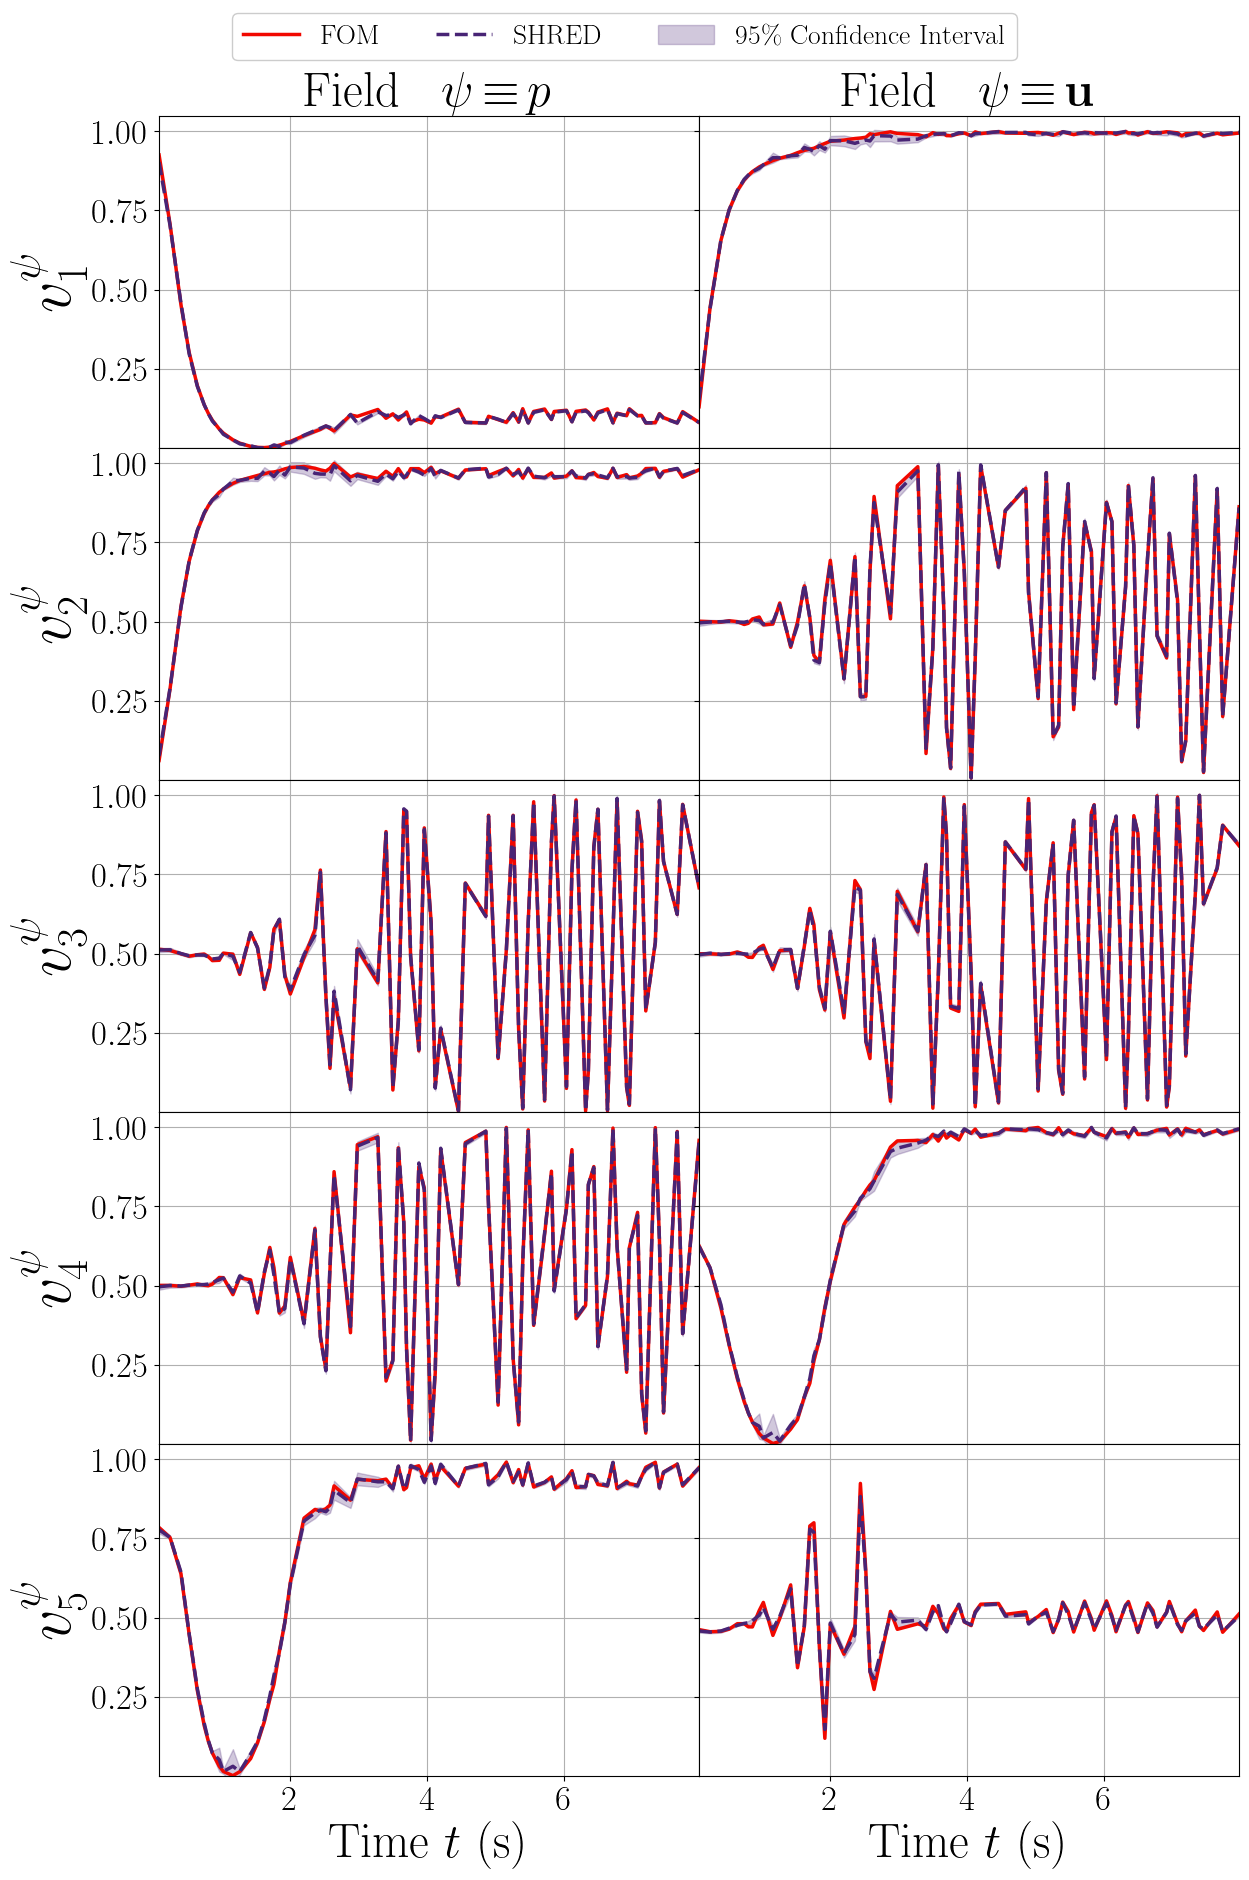

In [33]:
from matplotlib import cm

fields_idx_to_plot = [0,1]
modes_to_plot = np.arange(0, 5, 1)

nrows = len(modes_to_plot)  # Inverted
ncols = len(fields_idx_to_plot)  # Inverted

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(6 * ncols, 4 * nrows))
axs = axs.reshape(nrows, ncols)

ls = 2.5

for jj, field_i in enumerate(fields_idx_to_plot):  # Switched loop variables
    idx_to_plot = np.arange(modes_to_plot[0] + sum(Nmodes[:field_i]),
                            modes_to_plot[-1] + sum(Nmodes[:field_i])+1,
                            1,
                            dtype=int)

    colors = cm.viridis(np.linspace(0.1,0.95,1))
    colors_gt = cm.jet_r(np.linspace(0.1,0.95,1))

    for ii, idx in enumerate(idx_to_plot):  # Switched loop variables
        for param_to_plot in range(1):
            axs[ii, jj].plot(times[test_indices], reshaped_test_POD_out[param_to_plot,:,idx],
                            '-', linewidth=ls, c=colors_gt[param_to_plot], label=r'FOM')
            axs[ii, jj].plot(times[test_indices], reshaped_POD_test_out_pred['mean'][param_to_plot,:,idx],
                                '--', c=colors[param_to_plot], label=r'SHRED', linewidth=ls)
            axs[ii, jj].fill_between(times[test_indices],
                                    y1 = reshaped_POD_test_out_pred['mean'][param_to_plot,:,idx] - 1.96 * reshaped_POD_test_out_pred['std'][param_to_plot,:,idx],
                                    y2 = reshaped_POD_test_out_pred['mean'][param_to_plot,:,idx] + 1.96 * reshaped_POD_test_out_pred['std'][param_to_plot,:,idx],
                                    color=colors[param_to_plot], alpha=0.25, label=r'95\% Confidence Interval')
        axs[ii,jj].grid()
        axs[ii,jj].tick_params(axis='both', labelsize=25)
        # axs[ii, jj].set_xlim(0, times[test_indices][-1])
        axs[ii, jj].set_xlim(times[test_indices][0], times[test_indices][-1])
        axs[ii, jj].set_ylim(0, 1.05)
        # axs[ii, jj].set_xticks(np.arange(0, times[-1]+0.1, 1000))
        # axs[ii, jj].set_xticks(np.arange(6.5, times[-1]+0.1, 1000))
        axs[ii, jj].set_yticks(np.arange(0.25, 1.01, 0.25))
    
# [axs[ii, 0].set_title(r'Rank $r='+str(ii+1)+'$', fontsize=35) for ii in range(nrows)]  # Adjusted title placement
[axs[ii, 0].set_ylabel(r'$v_{'+str(ii+1+modes_to_plot[0])+'}^{\psi}$', fontsize=45) for ii in range(nrows)]  # Adjusted ylabel placement
[axs[-1, ii].set_xlabel(r'Time $t$ (s)', fontsize=35) for ii in range(ncols)]  # Adjusted xlabel placement
[axs[0, ii].set_title(r'Field $\;\;\psi\,{\equiv}\,'+tex_var_names[fields_idx_to_plot[ii]]+'$', fontsize=35) for ii in range(ncols)]  # Adjusted title placement

Line, Label = axs[0,0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=20, ncols=3, framealpha=1, loc='upper center')

fig.subplots_adjust(left=0, hspace=0.0, top=0.94, wspace=0.)

## Project back to the high-dimensional space
The SHRED architecture is trained to predict the POD coefficients given the sensor measures. The POD coefficients are then used to reconstruct the high-dimensional state.

The error is computed using the Euclidian norm

In [34]:
from tqdm import tqdm
from IPython.display import clear_output as clc

ave_rel_errors = {
    'mean': np.zeros((len(var_names), Ns, len(test_indices))),
    'std' : np.zeros((len(var_names), Ns, len(test_indices)))
}

for field_i in range(len(var_names)):
    field = var_names[field_i]
    idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

    for param_to_recon in tqdm(range(Ns), 'Computing error for '+field):
        fom = snapshots[field][param_to_recon][test_indices].T

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['mean'].shape)
        _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['std'].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['std'].shape) - vpod_scaler.data_min_

        recon     = modes[field][:, :Nmodes[field_i]] @ _tmp_mean_v[param_to_recon, :, idx_to_rec]
        std_recon = modes[field][:, :Nmodes[field_i]] @ _tmp_std_v[ param_to_recon, :, idx_to_rec]

        ave_rel_errors['mean'][field_i, param_to_recon] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, param_to_recon]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

        del fom, recon, std_recon
    clc()

Let us plot the errors using bar plots

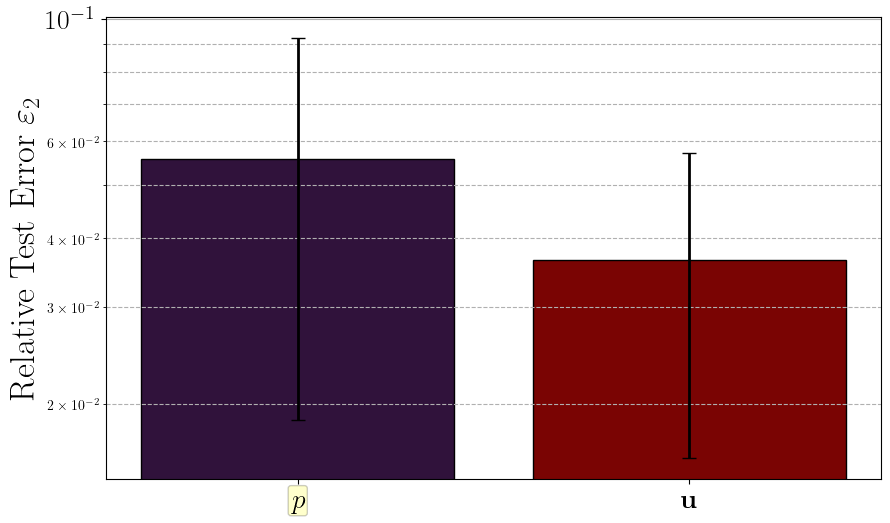

In [35]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,6))

colors = cm.turbo(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), ave_rel_errors['mean'].mean(axis=2).mean(axis=1), 
        yerr = ave_rel_errors['mean'].mean(axis=1).std(axis=1), capsize=5,
        color = colors,
        edgecolor='black',error_kw={'elinewidth': 2, 'ecolor': 'black', 'capsize': 5})

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

xticks = axs.get_xticklabels()
xticks[measured_field].set_color('black') 
xticks[measured_field].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.2))


### Contour plots
Let us plot the contour plots of the pressure and velocity field at different time steps

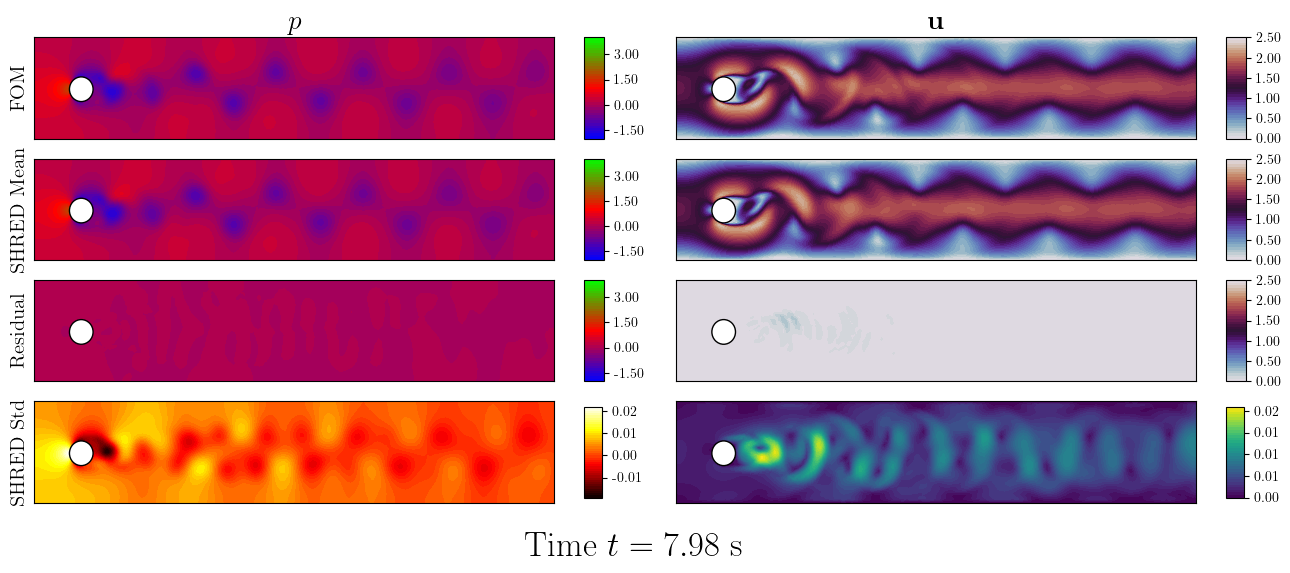

In [37]:
import matplotlib.ticker as mticker

ncols = len(var_names)  # Swap rows and columns
nrows = 4

import os
path_figs = f'{path_shred}/Figs/'
os.makedirs(path_figs, exist_ok=True)

levels = [np.linspace(-2, 4, 40), np.linspace(0, 2.5, 40)]
cmaps_std = [cm.hot, cm.viridis]

save_fig = False

fontsize=15

sampling = 5
for tt in range(sampling - 1, len(test_indices), sampling):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * nrows * plotter.aspect))

    for field_i, field in enumerate(var_names):
        fom = snapshots[field][0, test_indices[tt]].T
        idx_to_rec = np.arange(sum(Nmodes[:field_i]), sum(Nmodes[:field_i + 1]), 1, dtype=int)

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['mean'].shape)
        _tmp_std_v = vpod_scaler.inverse_transform(reshaped_POD_test_out_pred['std'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out_pred['std'].shape) - vpod_scaler.data_min_

        recon = modes[field][:, :Nmodes[field_i]] @ _tmp_mean_v[param_to_recon, tt, idx_to_rec]
        std_recon = modes[field][:, :Nmodes[field_i]] @ _tmp_std_v[param_to_recon, tt, idx_to_rec]
        residual = fom - recon #np.abs(fom - recon)

        fom_cont = plotter.plot_contour(axs[0, field_i], fom, cmap=cmaps[field_i], levels=levels[field_i])
        plotter.plot_contour(axs[1, field_i], recon, cmap=cmaps[field_i], levels=levels[field_i])
        std_cont = plotter.plot_contour(axs[3, field_i], std_recon, cmap=cmaps_std[field_i], levels=40)
        res_cont = plotter.plot_contour(axs[2, field_i], residual, cmap=cmaps[field_i], levels=levels[field_i])

        axs[0, field_i].set_title(r'$' + tex_var_names[field_i] + '$', fontsize=20)

        # Create colorbars with increased thickness and controlled tick labels
        formatter = mticker.FuncFormatter(lambda x, _: f"{x:.2f}")

        cbar1 = fig.colorbar(fom_cont, ax=axs[0, field_i], orientation='vertical', pad=0.05, fraction=0.08, aspect=5)
        cbar1.locator = mticker.MaxNLocator(nbins=5)
        cbar1.formatter = formatter
        cbar1.update_ticks()

        cbar2 = fig.colorbar(fom_cont, ax=axs[1, field_i], orientation='vertical', pad=0.05, fraction=0.08, aspect=5)
        cbar2.locator = mticker.MaxNLocator(nbins=5)
        cbar2.formatter = formatter
        cbar2.update_ticks()

        cbar3 = fig.colorbar(std_cont, ax=axs[3, field_i], orientation='vertical', pad=0.05, shrink=0.9, fraction=0.08, aspect=5)
        cbar3.locator = mticker.MaxNLocator(nbins=5)
        cbar3.formatter = formatter
        cbar3.update_ticks()

        cbar4 = fig.colorbar(res_cont, ax=axs[2, field_i], orientation='vertical', pad=0.05, fraction=0.08, aspect=5)
        cbar4.locator = mticker.MaxNLocator(nbins=5)
        cbar4.formatter = formatter
        cbar4.update_ticks()

    axs[0, 0].set_ylabel('FOM', fontsize=fontsize)
    axs[1, 0].set_ylabel('SHRED Mean', fontsize=fontsize)
    axs[3, 0].set_ylabel('SHRED Std', fontsize=fontsize)
    axs[2, 0].set_ylabel('Residual', fontsize=fontsize)

    fig.text(0.5, 0.01, f'Time $t = {times[test_indices[tt]]:.2f}$ s', ha='center', fontsize=fontsize+10)

    fig.subplots_adjust(wspace=0.075, bottom=0.1)

    if save_fig:
        fig.savefig(f'{path_figs}FlowOverCyl_{tt}.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()
        clc(wait=True)
    plt.close(fig)

